# B-splineデモ

Noshita, Koji <noshita@morphometrics.jp>

できるだけシンプルなB-spline fittingによるcurve fragmentの後処理のデモンストレーション

## 方針

* [make_lsq_spline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.make_lsq_spline.html)を利用する
* 周期性は仮定しない
* （曲線上の位置を示す）パラメータへは微小ノイズを与えて同じ値が含まれないようにするハックをおこなう

In [34]:
import glob, pickle

import numpy as np
import scipy as sp
import pandas as pd

from scipy.interpolate import make_lsq_spline, make_smoothing_spline

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [2]:
def cvt_polar(x,y):
    """Convert to polar coordinate system
    x, y -> r, theta
    """
    r = np.sqrt(x**2+y**2)
    theta = np.sign(y)*np.arccos(x/np.sqrt(x**2+y**2))
    return r, theta

def generate_knots(start, end, n_interval, d):
    """Generate knot vector
    Parameters
    ==============
    start: float
    end: float
        start and end of knots
    n_interval: int
        number of interval
    d: int
        degree of B-spline
    
    Returns
    ==============
    knots: array, shape(n_interval+2*dim + 1)
        knot vector
    
    """
    step = (end-start)/n_interval
    knots_ = [i for i in np.arange(start, end+step, step)]
    knots_p = [knots_[0] for i in range(d)]
    knots_a = [knots_[-1] for i in range(d)]
    
    knots = np.array(knots_p + knots_ + knots_a)
    return knots

## データ読み込み・確認

In [24]:
FILE_PATH = "../data/Bspline_202303/opt_curve_fragment/q_a/3mm/q_3_a/32_cfs.pickle"

with open(FILE_PATH, "rb") as f:
    curve_fragments = pickle.load(f)
len(curve_fragments)

8

In [229]:
coord_3d = np.concatenate(curve_fragments[4])

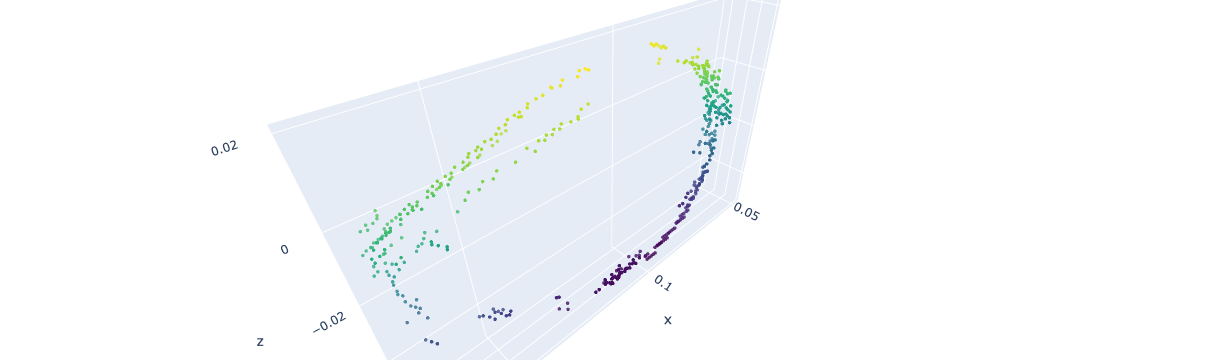

In [230]:
x,y,z = coord_3d.T

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=1,
        color=z,                
        colorscale='Viridis',   
        opacity=0.8
    )
)])

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0), 
    scene={"aspectmode":"data"}
)

## データ前処理

In [231]:
pca = PCA(n_components=2)
coord_2d = pca.fit_transform(coord_3d)

<Axes: >

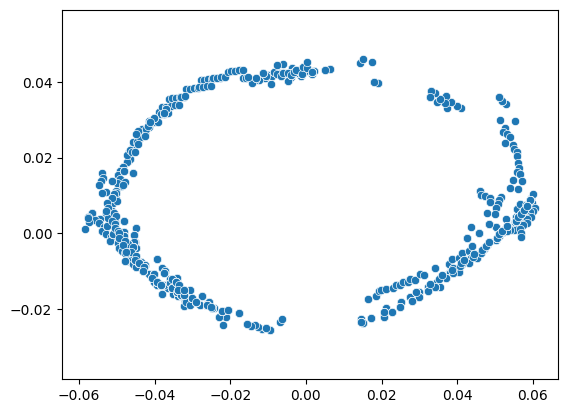

In [232]:
fig, ax = plt.subplots(1, 1)
ax.axis('equal')
sns.scatterplot(x=coord_2d[:,0], y=coord_2d[:,1], ax=ax)

In [233]:
# thetaは-Pi/2から3Pi/2までとする
# 開始，終了点の曲率を低くするためのハック
r, theta = cvt_polar(coord_2d[:,0], coord_2d[:,1])
# theta = np.array([t+2*np.pi if t < -np.pi/2 else t for t in theta])

<Axes: >

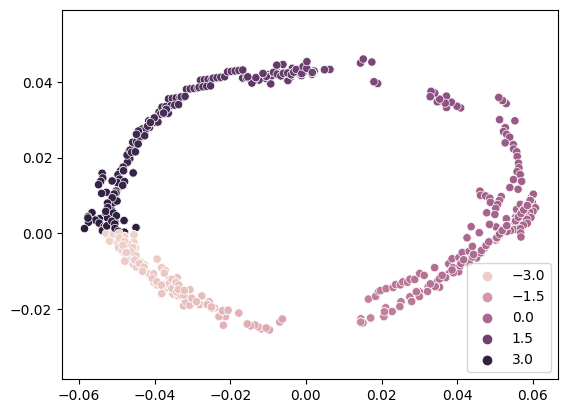

In [234]:
fig, ax = plt.subplots(1, 1)
ax.axis('equal')
sns.scatterplot(x=coord_2d[:,0], y=coord_2d[:,1], hue=theta, ax=ax)

In [67]:
knots = generate_knots(-np.pi+np.pi/2, np.pi+np.pi/2, 16, 3)
# knots = generate_knots(-np.pi, np.pi, 16, 3)
knots

array([-3.14159265, -3.14159265, -3.14159265, -3.14159265, -2.74889357,
       -2.35619449, -1.96349541, -1.57079633, -1.17809725, -0.78539816,
       -0.39269908,  0.        ,  0.39269908,  0.78539816,  1.17809725,
        1.57079633,  1.96349541,  2.35619449,  2.74889357,  3.14159265,
        3.14159265,  3.14159265,  3.14159265])

### （パラメータに）微小なノイズを加えた上で，点を並び替える
make_lsq_splineが昇順に並んだ位置パラメータを要求するので，その対応

In [136]:
theta_r = theta + (10**-8)*np.random.random(len(theta))
idx_sorted = np.argsort(theta_r)
theta_sorted = theta_r[idx_sorted]
coord_3d_sorted = coord_3d[idx_sorted]

print("original: ", theta.shape, "sorted: ", np.unique(theta_sorted).shape)

original:  (110538,) sorted:  (110538,)


## B-spline fitting

In [55]:
spl = make_lsq_spline(theta_sorted, coord_3d_sorted, t=knots, axis=0)

In [56]:
theta_recon = np.linspace(-np.pi+np.pi/2, np.pi+np.pi/2, 360)
coord_3d_recon = spl(theta_recon)

<Axes: >

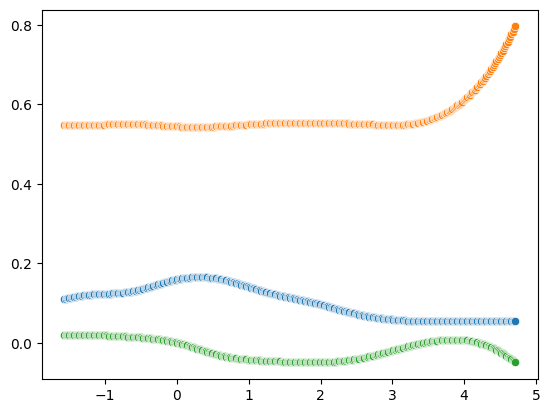

In [57]:
sns.scatterplot(x=theta_recon, y=coord_3d_recon[:, 0])
sns.scatterplot(x=theta_recon, y=coord_3d_recon[:, 1])
sns.scatterplot(x=theta_recon, y=coord_3d_recon[:, 2])

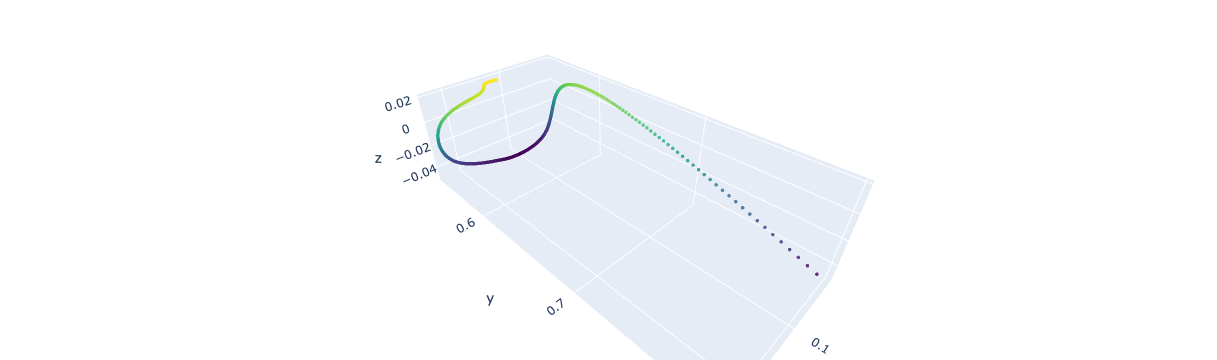

In [58]:
x,y,z = coord_3d_recon.T

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=1,
        color=z,                
        colorscale='Viridis',   
        opacity=0.8
    )
)])

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0), 
    scene={"aspectmode":"data"}
)

## 個体内の葉すべてでの確認

In [3]:
file_pathes = glob.glob("../data/Bspline_202303/opt_curve_fragment/*/*/*/*_cfs.pickle")
len(file_pathes)

81

In [4]:
FILE_PATH = file_pathes[3]
print(FILE_PATH)

with open(FILE_PATH, "rb") as f:
    curve_fragments = pickle.load(f)

../data/Bspline_202303/opt_curve_fragment/q_aothick/3mm/q_1_a/32_cfs.pickle


In [5]:
N_INTERVAL = 16
DEGREE = 3

theta_list = []
curve_list = []

for cf in curve_fragments:
    coord_3d = np.concatenate(cf)
    
    pca = PCA(n_components=2)
    coord_2d = pca.fit_transform(coord_3d)
    
    _, theta = cvt_polar(coord_2d[:,0], coord_2d[:,1])
    theta = np.array([t+2*np.pi if t < -np.pi/2 else t for t in theta])
    
    knots = generate_knots(-np.pi+np.pi/2, np.pi+np.pi/2, N_INTERVAL, DEGREE)
    
    sort_flag = True
    theta_sorted = None
    coord_3d_sorted = None
    while sort_flag:
        theta_r = theta + (10**-8)*np.random.random(len(theta))
        idx_sorted = np.argsort(theta_r)
        theta_sorted = theta_r[idx_sorted]
        coord_3d_sorted = coord_3d[idx_sorted]

        if len(theta) == len(np.unique(theta_sorted)):
            sort_flag = False
            
    spl = make_lsq_spline(theta_sorted, coord_3d_sorted, t=knots, axis=0)
    theta_recon = np.linspace(-np.pi+np.pi/2, np.pi+np.pi/2, 360)
    coord_3d_recon = spl(theta_recon)
    
    theta_list.append(theta_recon)
    curve_list.append(coord_3d_recon)

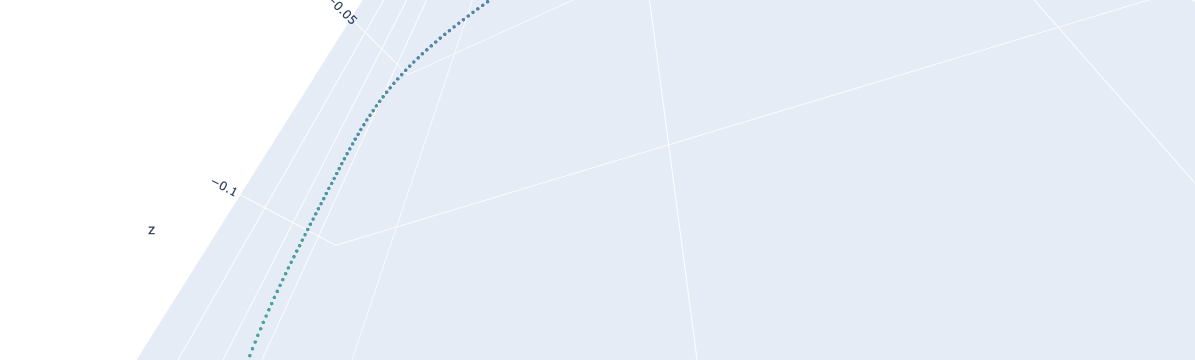

In [70]:
x,y,z = curve_list[3].T
t = theta_list[3]

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=1,
        color=t,                
        colorscale='Viridis',   
        opacity=0.8
    )
)])

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0), 
    scene={"aspectmode":"data"}
)

### まとめて表示

In [6]:
df_list = []
for i, [t, coord] in enumerate(zip(theta_list, curve_list)):
    df_tmp = pd.DataFrame(coord, columns=["x", "y", "z"])
    df_tmp["theta"] = t
    df_tmp["leaf_id"] = i
    df_list.append(df_tmp.copy())

df_curves = pd.concat(df_list)
df_curves = df_curves[["leaf_id", "theta", "x", "y", "z"]]
df_curves

leaf_id     theta         x         y         z
0          0 -1.570796 -0.155549  0.332420 -0.033880
1          0 -1.553294 -0.154343  0.332750 -0.034131
2          0 -1.535793 -0.153150  0.333069 -0.034395
3          0 -1.518291 -0.151970  0.333378 -0.034670
4          0 -1.500789 -0.150798  0.333679 -0.034955
..       ...       ...       ...       ...       ...
355        7  4.642381 -0.210373  0.156737  0.145566
356        7  4.659883 -0.210054  0.156842  0.145000
357        7  4.677385 -0.209751  0.156889  0.144478
358        7  4.694887 -0.209465  0.156875  0.144000
359        7  4.712389 -0.209199  0.156795  0.143570

[2880 rows x 5 columns]

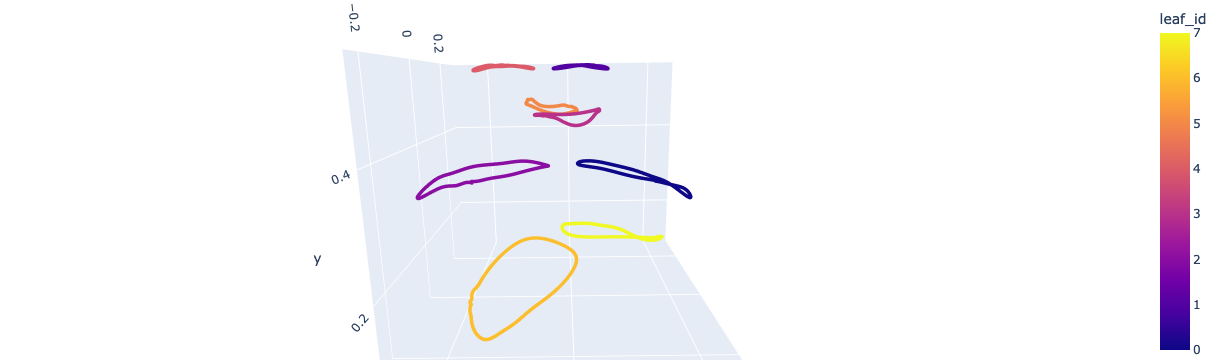

In [7]:
fig = px.scatter_3d(
    df_curves,
    x="x",
    y="y",
    z="z",
    color="leaf_id",
)
fig.update_traces(
    marker=dict(size=1)
)
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0), 
    scene={"aspectmode":"data"}
)

## 差の計算
[Shapely](https://shapely.readthedocs.io/en/stable/)を使って，Fréchet距離を計算する

In [40]:
from shapely import linearrings, frechet_distance, hausdorff_distance

In [36]:
poly1 = linearrings(curve_list[0])
poly2 = linearrings(curve_list[1])

In [46]:
frechet_distance(poly1, poly2)

0.3119384263561945

In [47]:
frechet_distance(poly2, poly1)

0.3119384263561945

In [41]:
hausdorff_distance(poly1, poly2)

0.3328635115075736

## 閉曲線版推定

In [141]:
from scipy.optimize import curve_fit
from scipy.interpolate import BSpline

In [221]:
def generate_knots_circular_bspline(start, end, n_interval, d):
    
    step = (end-start)/n_interval
    knots_ = [i for i in np.arange(start, end+step, step)]
    knots_p = [knots_[i+len(knots_)-2] - (knots_[-1] - knots_[0]) for i in range(1-d, 1)]
    knots_a = [knots_[i-len(knots_)]+ (knots_[-1]-knots_[0]) for i in range(len(knots_)+1,len(knots_)+d+2)]
    
    knots = knots_p + knots_ + knots_a
    
    return np.array(knots)

In [246]:
degree = 3
knots = generate_knots_circular_bspline(-np.pi, np.pi, 16, 3)

def bspline_wrapper(theta, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19):
    bspline = BSpline(knots, 
                      [c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19, 0], 
                      degree, extrapolate="periodic")
    return bspline(theta)

In [247]:
theta_r = theta + (10**-8)*np.random.random(len(theta))
idx_sorted = np.argsort(theta_r)
theta_sorted = theta_r[idx_sorted]
coord_3d_sorted = coord_3d[idx_sorted]

print("original: ", theta.shape, "sorted: ", np.unique(theta_sorted).shape)

original:  (1693,) sorted:  (1693,)


In [248]:
popt_x, pcov_x = curve_fit(bspline_wrapper, theta_sorted, coord_3d_sorted[:,0], bounds=(-2,2), ftol=10**-8)
popt_y, pcov_y = curve_fit(bspline_wrapper, theta_sorted, coord_3d_sorted[:,1], bounds=(-2,2), ftol=10**-8)
popt_z, pcov_z = curve_fit(bspline_wrapper, theta_sorted, coord_3d_sorted[:,2], bounds=(-2,2), ftol=10**-8)

In [224]:
popt_x

array([-0.20249608, -0.21099329, -0.2282202 , -0.24435566, -0.25095377,
       -0.22020129, -0.20139157, -0.17410984, -0.14579776, -0.09807686,
       -0.03855139, -0.00179147, -0.03949152, -0.11135745, -0.15794855,
       -0.1784989 , -0.19776585, -0.21097102, -0.23057402])

In [225]:
pcov_x

array([[ 8.56641371e-07, -1.30552626e-07,  5.01944038e-08,
        -3.11901860e-08,  1.86776101e-08, -8.52195152e-09,
         4.37214561e-09, -2.25667191e-09,  1.27292289e-09,
        -7.28762816e-10,  5.96259831e-10, -6.01906852e-10,
         1.51246645e-10, -5.64595160e-11,  2.60353604e-11,
        -1.54703549e-11,  1.22894733e-11, -1.72257376e-11,
         7.50429174e-11],
       [-1.30552626e-07,  2.49673164e-08, -1.07668905e-08,
         7.00791968e-09, -4.25449755e-09,  1.94495809e-09,
        -9.98352757e-10,  5.15354529e-10, -2.90704824e-10,
         1.66432716e-10, -1.36172319e-10,  1.37462038e-10,
        -3.45413461e-11,  1.28940890e-11, -5.94589328e-12,
         3.53308261e-12, -2.80664050e-12,  3.93397271e-12,
        -1.71381218e-11],
       [ 5.01944038e-08, -1.07668905e-08,  6.62843396e-09,
        -4.84342697e-09,  3.03342500e-09, -1.39272204e-09,
         7.15681030e-10, -3.69528498e-10,  2.08459430e-10,
        -1.19347462e-10,  9.76483824e-11, -9.85733373e-11,
    

In [216]:
popt_y

array([0.34740104, 0.32597214, 0.32212798, 0.30250014, 0.29424269,
       0.31886614, 0.32836964, 0.33598077, 0.34370198, 0.35480412,
       0.36906059, 0.36561679, 0.36954903, 0.35313767, 0.34584529,
       0.3389448 , 0.33421036, 0.32854899, 0.31898515])

In [217]:
pcov_y

array([[ 9.02666838e-07, -1.37566933e-07,  5.28912393e-08,
        -3.28659665e-08,  1.96811173e-08, -8.97981734e-09,
         4.60705143e-09, -2.37791796e-09,  1.34131425e-09,
        -7.67917648e-10,  6.28295567e-10, -6.34245991e-10,
         1.59372796e-10, -5.94929622e-11,  2.74341834e-11,
        -1.63015432e-11,  1.29497599e-11, -1.81512388e-11,
         7.90748093e-11],
       [-1.37566933e-07,  2.63087557e-08, -1.13453719e-08,
         7.38443989e-09, -4.48308240e-09,  2.04945644e-09,
        -1.05199207e-09,  5.43043401e-10, -3.06323758e-10,
         1.75374782e-10, -1.43488560e-10,  1.44847573e-10,
        -3.63971771e-11,  1.35868602e-11, -6.26535311e-12,
         3.72290741e-12, -2.95743516e-12,  4.14533646e-12,
        -1.80589156e-11],
       [ 5.28912393e-08, -1.13453719e-08,  6.98456523e-09,
        -5.10365371e-09,  3.19640429e-09, -1.46754995e-09,
         7.54133008e-10, -3.89382456e-10,  2.19659499e-10,
        -1.25759741e-10,  1.02894817e-10, -1.03869467e-10,
    

In [249]:
theta_recon = np.linspace(-np.pi, np.pi, 360)
coord_3d_recon = np.stack([
    bspline_wrapper(theta_recon, *popt_x), 
    bspline_wrapper(theta_recon, *popt_y), 
    bspline_wrapper(theta_recon, *popt_z), 
]).T

<Axes: >

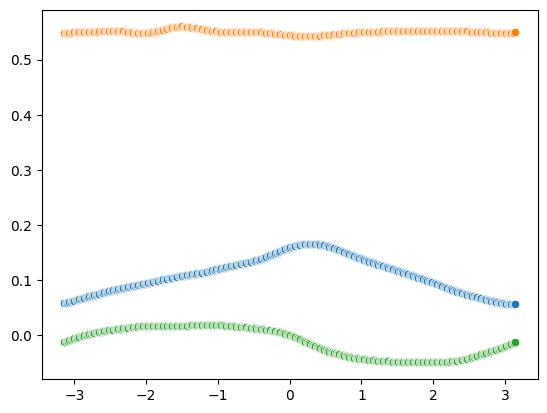

In [250]:
sns.scatterplot(x=theta_recon, y=coord_3d_recon[:,0])
sns.scatterplot(x=theta_recon, y=coord_3d_recon[:,1])
sns.scatterplot(x=theta_recon, y=coord_3d_recon[:,2])

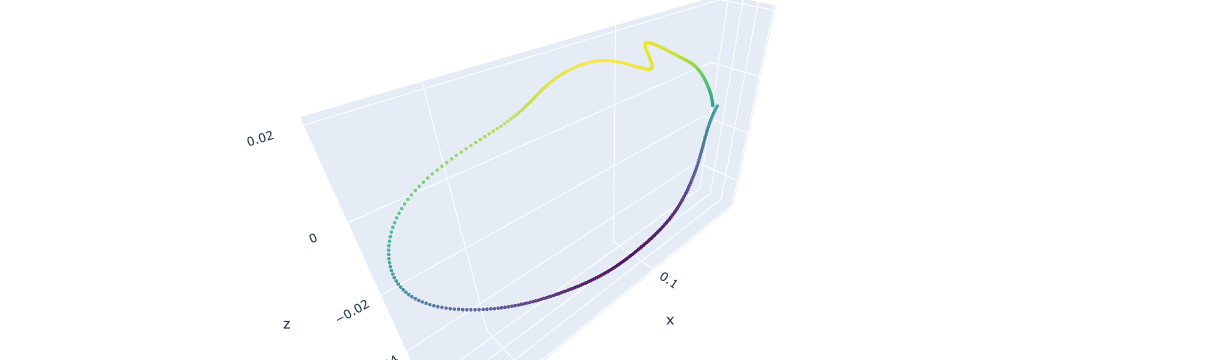

In [251]:
x,y,z = coord_3d_recon.T

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=1,
        color=z,                
        colorscale='Viridis',   
        opacity=0.8
    )
)])

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0), 
    scene={"aspectmode":"data"}
)